In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data, create_feature_df
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
df_real = pd.read_csv('/mnt/HARD/Diplom/MinMax/results/lof_real.csv')
df_gen = pd.read_csv('/mnt/HARD/Diplom/MinMax/results/lof_gen.csv')

df_real['date_time_utc'] = pd.to_datetime(df_real['date_time_utc'])
df_gen['date_time_utc'] = pd.to_datetime(df_gen['date_time_utc'])

detectors = [col.split('_', 2)[-1] for col in df_real.columns if col.startswith('decision_function_')]

## Linear Transformation 

In [3]:
scaler = MinMaxScaler()
for detector in detectors:
    scl = copy(scaler)
    gen = df_gen['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    real = df_real['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    df_gen['decision_function_lt_{0}'.format(detector)] = scl.fit_transform(gen)
    df_real['decision_function_lt_{0}'.format(detector)] = scl.transform(real)
    #df_gen['decision_function_lt_{0}'.format(detector)] = gen
    #df_real['decision_function_lt_{0}'.format(detector)] = real
    
lt_cols = [col for col in df_gen if col.startswith('decision_function_lt_')]
#df_gen['decision_function_lt'] = scaler.fit_transform(df_gen[lt_cols].sum(1).values.reshape(-1, 1))
#df_real['decision_function_lt'] = scaler.transform(df_real[lt_cols].sum(1).values.reshape(-1, 1))
df_gen['decision_function_lt'] = df_gen[lt_cols].sum(1) / len(detectors)
df_real['decision_function_lt'] = df_real[lt_cols].sum(1) / len(detectors)

In [4]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.03, 0.05, 0.001):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_lt'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_lt'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/lof_fb_lt.csv', index=False)

threshold: 0.03 	 f1_gen: 0.474 	 f1_real: 0.048
threshold: 0.03 	 f1_gen: 0.502 	 f1_real: 0.045
threshold: 0.03 	 f1_gen: 0.530 	 f1_real: 0.046
threshold: 0.03 	 f1_gen: 0.548 	 f1_real: 0.043
threshold: 0.03 	 f1_gen: 0.574 	 f1_real: 0.040
threshold: 0.04 	 f1_gen: 0.592 	 f1_real: 0.036
threshold: 0.04 	 f1_gen: 0.599 	 f1_real: 0.037
threshold: 0.04 	 f1_gen: 0.607 	 f1_real: 0.034
threshold: 0.04 	 f1_gen: 0.610 	 f1_real: 0.038


KeyboardInterrupt: 

In [ ]:
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/lof_fb_lt.csv', index=False)

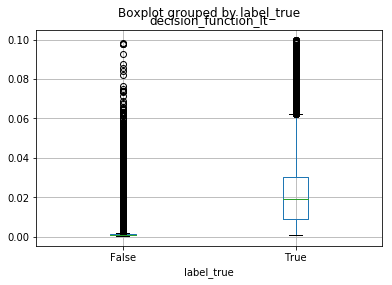

In [39]:
%matplotlib inline

df_gen[df_gen['decision_function_lt'] < 0.1].boxplot('decision_function_lt', 'label_true')

## Weigted Linear Trasformation

In [28]:
scaler = MinMaxScaler()

for detector in detectors:
    scl = copy(scaler)
    gen = df_gen['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    real = df_real['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    #df_gen['decision_function_lt_{0}'.format(detector)] = scl.fit_transform(gen)
    #df_real['decision_function_lt_{0}'.format(detector)] = scl.transform(real)
    df_gen['decision_function_lt_{0}'.format(detector)] = gen
    df_real['decision_function_lt_{0}'.format(detector)] = real
    

corr_columns = [col for col in df_gen.columns if col.startswith('decision_function_lt_') or col=='label_true']
corr = df_gen[corr_columns].corr()['label_true']

for detector in detectors:
    weight = corr['decision_function_lt_{0}'.format(detector)]
    df_gen['decision_function_wlt_{0}'.format(detector)] = df_gen['decision_function_lt_{0}'.format(detector)] * weight
    df_real['decision_function_wlt_{0}'.format(detector)] = df_real['decision_function_lt_{0}'.format(detector)] * weight

wlt_cols = [col for col in df_gen if col.startswith('decision_function_wlt_')]
df_gen['decision_function_wlt'] = scaler.fit_transform(df_gen[lt_cols].sum(1).values.reshape(-1, 1))
df_real['decision_function_wlt'] = scaler.fit_transform(df_real[lt_cols].sum(1).values.reshape(-1, 1))

df_gen['decision_function_wlt'] = df_gen['decision_function_wlt'] / (corr.sum() - 1)
df_real['decision_function_wlt'] = df_real['decision_function_wlt'] / (corr.sum() - 1)

In [31]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.04, 0.10, 0.002):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_wlt'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_wlt'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ridge_fb_wlt.csv', index=False)

threshold: 0.04 	 f1_gen: 0.929 	 f1_real: 0.420
threshold: 0.04 	 f1_gen: 0.940 	 f1_real: 0.480
threshold: 0.04 	 f1_gen: 0.947 	 f1_real: 0.531
threshold: 0.05 	 f1_gen: 0.952 	 f1_real: 0.575
threshold: 0.05 	 f1_gen: 0.956 	 f1_real: 0.610
threshold: 0.05 	 f1_gen: 0.959 	 f1_real: 0.627
threshold: 0.05 	 f1_gen: 0.960 	 f1_real: 0.658
threshold: 0.05 	 f1_gen: 0.960 	 f1_real: 0.672
threshold: 0.06 	 f1_gen: 0.963 	 f1_real: 0.691
threshold: 0.06 	 f1_gen: 0.964 	 f1_real: 0.702
threshold: 0.06 	 f1_gen: 0.964 	 f1_real: 0.712
threshold: 0.06 	 f1_gen: 0.963 	 f1_real: 0.708
threshold: 0.06 	 f1_gen: 0.960 	 f1_real: 0.696
threshold: 0.07 	 f1_gen: 0.957 	 f1_real: 0.699
threshold: 0.07 	 f1_gen: 0.955 	 f1_real: 0.682
threshold: 0.07 	 f1_gen: 0.954 	 f1_real: 0.677
threshold: 0.07 	 f1_gen: 0.953 	 f1_real: 0.689
threshold: 0.07 	 f1_gen: 0.949 	 f1_real: 0.672
threshold: 0.08 	 f1_gen: 0.948 	 f1_real: 0.631
threshold: 0.08 	 f1_gen: 0.943 	 f1_real: 0.613
threshold: 0.08 	 f1

In [32]:
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/lof_fb_wlt.csv', index=False)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for detector in detectors:
    df_gen['decision_function_log_{0}'.format(detector)] = df_gen['decision_function_{0}'.format(detector)]
    df_real['decision_function_log_{0}'.format(detector)] = df_real['decision_function_{0}'.format(detector)]

log_cols = [col for col in df_gen if col.startswith('decision_function_log_')]

X_train = df_gen[log_cols]
y_train = df_gen['label_true']

X_test = df_real[log_cols]
y_test = df_real['label_true']

clf = LogisticRegression()
clf.fit(X_train, y_train)

df_gen['decision_function_log'] = clf.decision_function(X_train)
df_real['decision_function_log'] = clf.decision_function(X_test)

df_gen['decision_function_log'] = scaler.fit_transform(df_gen['decision_function_log'].values.reshape(-1, 1))
df_real['decision_function_log'] = scaler.transform(df_real['decision_function_log'].values.reshape(-1, 1))

In [ ]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.12, 0.27, 0.01):
#for thresh in np.arange(0.2, 0.25, 0.01):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_log'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_log'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.4f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ridge_fb_log.csv', index=False)

## Plot

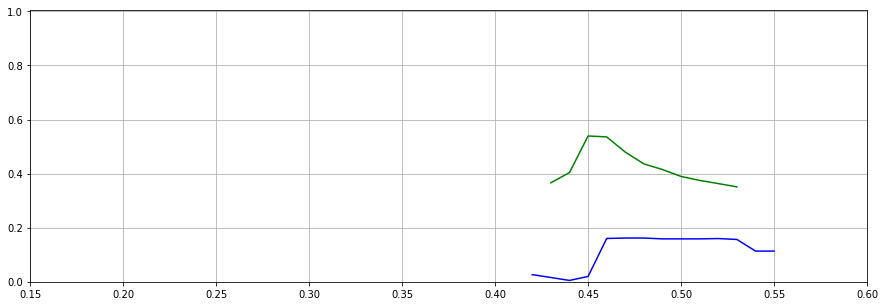

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

real = np.array([(r['Threshold'], r['F1']) for r in real_results])
generated = np.array([(r['Threshold'], r['F1']) for r in generated_results])

plt.figure(figsize=(15, 5))
plt.plot(real[:, 0], real[:, 1], c='b')
plt.plot(generated[:, 0], generated[:, 1], c='g')
plt.ylim(0.0, 1.005)
plt.xlim(0.15, 0.6)
plt.grid()
plt.show()

In [15]:
generated_opt_thresh = generated[np.argmax(generated[:, 1])][0]
real_opt_thresh = real[np.argmax(real[:, 1])][0]

opt_f1 = real[np.argmax(real[:, 1])][1]
chosen_f1 = real[np.argmax(generated[:, 1])][1]

print('Real optimal: \t{0:.3f} {1:.4f}'.format(real_opt_thresh, opt_f1))
print('Chosen one: \t{0:.3f} {1:.4f}'.format(generated_opt_thresh, chosen_f1))

Real optimal: 	0.470 0.1618
Chosen one: 	0.450 0.0050


In [16]:
df_1['label_predict'] = df_1['decision_function'] > generated_opt_thresh

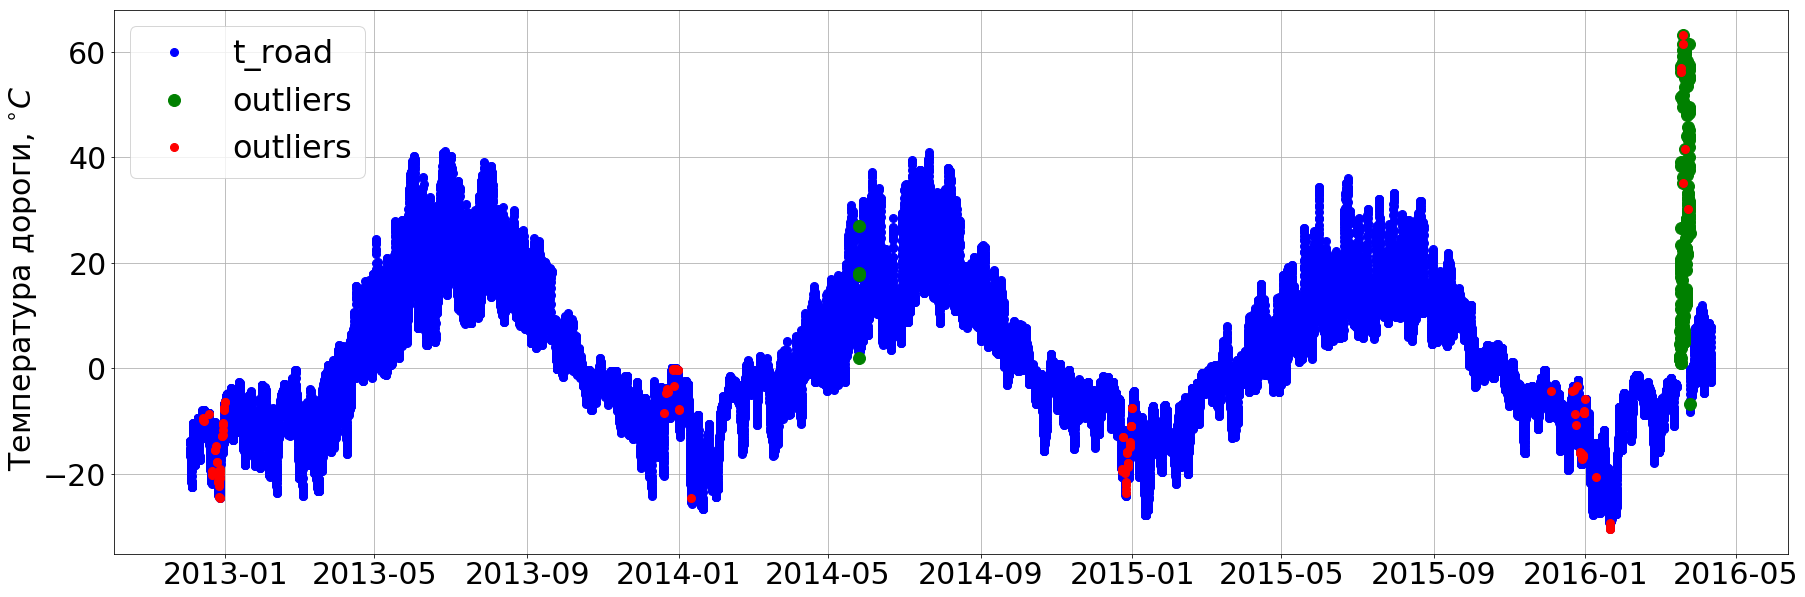

In [17]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_1[df_1['station_id']==1896].set_index('date_time_utc'))

start = pd.Timestamp(2012, 12, 1)
end = pd.Timestamp(2017, 2, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

In [23]:
import scipy as sp

scaler = MinMaxScaler()
for detector in detectors:
    scl = copy(scaler)
    gen = df_gen['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    mu_s = np.min(gen)
    sigma_s = np.std(gen)
    erf_gen = sp.special.erf((gen - mu_s) / (sigma_s * np.sqrt(2)))
    df_gen['decision_function_gt_{0}'.format(detector)] = np.maximum(0, erf_gen)
    
    real = df_real['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    erf_real = sp.special.erf((real - mu_s) / np.sqrt(sigma_s * 2))
    df_real['decision_function_gt_{0}'.format(detector)] = np.maximum(0, erf_real)
    
gt_cols = [col for col in df_gen if col.startswith('decision_function_gt_')]
df_gen['decision_function_gt'] = df_gen[gt_cols].sum(1) / len(detectors)
df_real['decision_function_gt'] = df_real[gt_cols].sum(1) / len(detectors)